In [114]:
import joblib
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Run ML Experiment

## Prepare Data

In [115]:
# Load Data 

PROJECT_DIR = Path(os.getcwd()).parent.absolute()
churn_filepath = PROJECT_DIR/'data'/'Churn_Modelling.csv'

In [116]:
df = pd.read_csv(churn_filepath)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [117]:
df.shape

(10000, 14)

In [118]:
# Are there missing values?
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [119]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [120]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'


X, y = df[cat_cols + num_cols], df[targ_col]

In [121]:
y.mean()

0.2037

In [122]:
# Data Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Train a model

In [123]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

# Select algorithm
clf = RandomForestClassifier(random_state=random_state,  **train_params)
# clf = LGBMClassifier(random_state=random_state, **train_params)
# clf = XGBClassifier(random_state=random_state, **train_params)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
        ]
    )
categorical_transformer = OrdinalEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Geography', 'Gender'])])),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [124]:
# Save model 

joblib.dump(model, PROJECT_DIR/'models/model.joblib')

['/Users/mnrozhkov/dev/iterative/examples/demo-bank-customer-churn/models/model.joblib']

## Evaluate

In [125]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

In [126]:
# Get predictions 

y_prob = model.predict_proba(X_test)
y_pred = (y_prob[:, 1] >= 0.5).astype(int)

In [127]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [128]:
# Calculate Metrics

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

print(f1)
print(roc_auc)

0.5688073394495413
0.8607069275362611


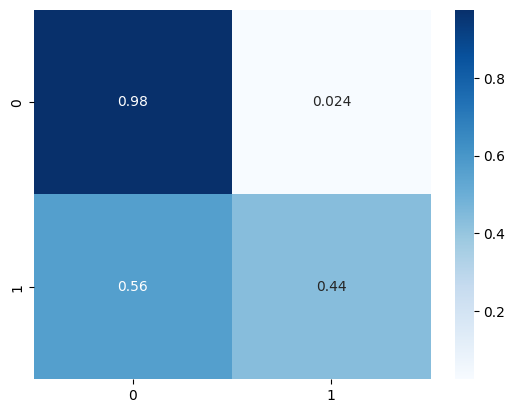

In [129]:
# Plot Confusion Matrix 

cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues) 

# Save image file
plt.savefig(PROJECT_DIR/'results/cm.png')

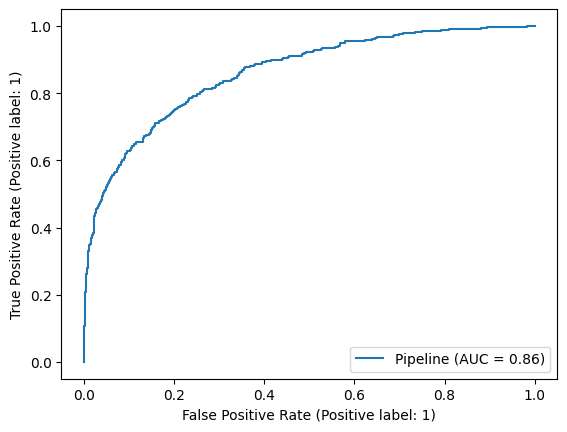

In [130]:
# ROC-AUC Curve

# fig, ax = plt.subplots()
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

# DVCLive: Simple metrics, plots and artifacts logging with Live

## 1 - Initiate a Live object
- "dvclive" dir is created by default
- all metrics, plots and artifaces saved there

In [131]:
from dvclive import Live

# DVCLive: Initiate Live object 
live = Live()

If you have a DVC Pipeline, run it with `dvc exp run`.
If you are using DVCLive alone, use `save_dvc_exp=True`.


## 2 - Log metrics 

In [132]:
# DVCLive: Log an existing image

live.log_metric('f1', f1)
live.log_metric('roc_auc', roc_auc)

## 3 - Log plots and images

In [133]:
# Log an existing image

live.log_image('cm.png', PROJECT_DIR/'results/cm.png')

In [134]:
# # Log plot 

# live.log_plot("confusion_matrix_plot", y_test, y_pred)

In [135]:
# Log sklearn plot 

# live.log_sklearn_plot("confusion_matrix", y_test, y_pred, name="cm.json")

In [136]:
# Log Matplotlib Figure as an image

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
live.log_image("roc.png", svc_disp.figure_)

## 4 - Log a model

In [137]:
# DVCLive: Log Model

live.log_artifact(
    path = PROJECT_DIR/'models/model.joblib',
    type = 'model', 
    cache  = False  # DVC stores metadata about the model in 'dvclive/dvc.yaml' without storing a copy in the DVC cache.
)

## 5 - Close Live object  

- Call Live.end() when the current experiment has ended

In [138]:
# DVCLive: call live.end() to make and display summary
# Docs: https://dvc.org/doc/dvclive/live/end#description 

live.end()

In [139]:
# # # DVCLive: live.end() is eqvivalent to the following calls 

# live.make_summary()  # Makes a summary `metrics.json` in the `live.dir` 
# live.make_report()   # Makes a 'report.html' in the `live.dir` 
# live.make_dvcyaml()  # Makes a 'dvc.yaml' with plots and metrics metadata

## 6 - Commit metrics 

In [140]:
# !git add dvclive      # Commit 'dvclive' dir to Git
# !git push             # Push changes to Git remote

# DVCLive: Live context manager and versioning with DVC

### 1 - Save Predictions

In [141]:
# Prepare Predictions Table

df_test = X_test.copy(deep=True)
df_test['true'] = y_test
df_test['pred'] = y_pred
df_test['prob'] = y_prob[:, 1]

df_test.head()

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,true,pred,prob
6252,Germany,Male,596,32,3,96709.07,2,0,0,41788.37,0,0,0.033832
4684,France,Male,623,43,1,0.00,2,1,1,146379.30,0,0,0.041014
1731,Spain,Female,601,44,4,0.00,2,1,0,58561.31,0,0,0.116535
4742,Germany,Male,506,59,8,119152.10,2,1,1,170679.74,0,0,0.154570
4521,Spain,Female,560,27,7,124995.98,1,1,1,114669.79,0,0,0.123252


In [142]:
# Save Predictions

df_test.to_csv(PROJECT_DIR/'results/predictions.csv', index=True)

### 2 - Calculcate and save Feature Importance

In [143]:
# Calculate Feature Importance for Train

perm = permutation_importance(
    model, X_train, y_train, n_repeats=3, random_state=0, n_jobs=2)


sorted_importances_idx = perm.importances_mean.argsort()
feat_imp_train = pd.DataFrame(
    perm.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

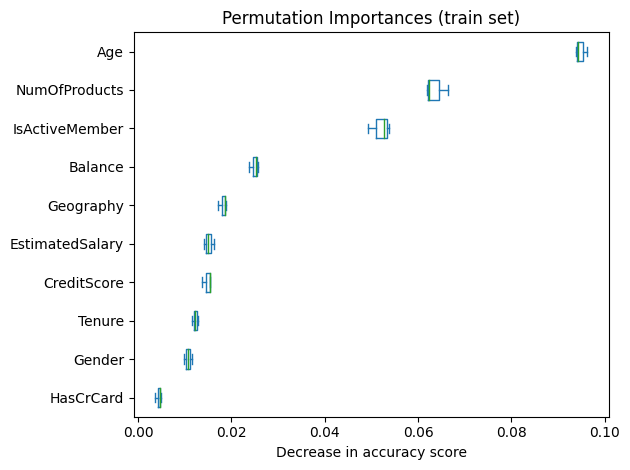

In [144]:
ax = feat_imp_train.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [145]:
# Prepare Feature Importance Table

fimp_df = (feat_imp_train
 .agg(['mean', 'std'], axis=0)
 .T.sort_values(by='mean', ascending=False)
)

fimp_df.head()

,mean,std
Age,0.094756,0.001336
NumOfProducts,0.063600,0.002433
IsActiveMember,0.051956,0.002318
Balance,0.024933,0.001058
Geography,0.018222,0.000888


In [146]:
# Save Feature Importance Table

fimp_df.to_csv(PROJECT_DIR/'results/feat_imp_train.csv', index=True)

### 3 - Log artifacts

Notes:
- `dir` Location of the directory to store outputs (default value is 'dvclive')
- If `dvcyaml=True` (default) and you include any of the fields in `[type, name, desc, labels, meta]`, it will add all the artifact's metadata to the corresponding dvc.yaml.
- Passing `type="model"` will mark it as a model for DVC and will make it appear in Studio model registry.
- `live.end()` is called automatically when exiting the context manager
- Docs: https://dvc.org/doc/dvclive/live/log_artifact 

In [147]:
# # DVCLive:  Save metrics, plots, and artifacts with the Live context manager

with Live(dir=PROJECT_DIR/'results/dvclive_artifacts', dvcyaml=True) as live:
    
    # DVCLive: Log Feature Importance image 
    ax = feat_imp_train.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (train set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    live.log_image(PROJECT_DIR/'results/feature_imp_train.png', ax.figure)  
    
    # DVCLive: log data artifact
    live.log_artifact(PROJECT_DIR/'results/predictions.csv') # path to an existing directory or file 
    
    # DVCLive: log data artifact (extended) 
    live.log_artifact(
        path = PROJECT_DIR/'results/feat_imp_train.csv',
        type = 'dataset',
        name = 'feature-importance-train', # custom name of an artifact (use dashes '-' instead of '_' underscores)
        desc = 'Permutation based Feature Importance for Train dataset',
        labels = ['train'],
        meta = {'n_repeats': 3},
        copy  = False,
        cache  = True, # version with DVC
    )

If you have a DVC Pipeline, run it with `dvc exp run`.
If you are using DVCLive alone, use `save_dvc_exp=True`.


## 4 - Commit and push to DVC remote storage

- We assume you have already setup [DVC Remote Storage](https://dvc.org/doc/user-guide/data-management/remote-storage#remote-storage)

In [148]:
# Commit and push changes to Git (metadata only)

# !git add ../results/dvclive_artifacts/ ../results/predictions.csv.dvc      
# !git push             

In [149]:
# Push to DVC remote storage

## You may create a 'local' remote for demo purposes
# !mkdir -p /tmp/dvc/dvclive
# !dvc remote add local /tmp/dvc/dvclive

## Push to DVC
# !dvc push -r local

Everything is up to date.                                                       


# DVCLive: Live experiments in Studio and DVC experiments

# DVC Report

metrics.json

|   accuracy |   step |
|------------|--------|
|    2.99573 |     19 |

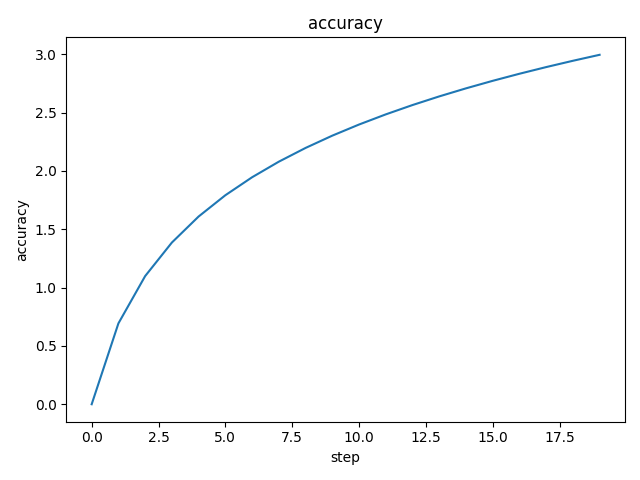


	results/dvclive_artifacts/metrics.json, results/dvclive_artifacts/dvc.yaml, results/dvclive_artifacts/report.html


In [151]:
from dvclive import Live
from math import log
import time

epochs = 20

with Live(dir=PROJECT_DIR/'results/dvclive_studio',
          dvcyaml=True,
          save_dvc_exp=True, # DVCLive will create a new DVC experiment 
          report='notebook', # Display a report in the Notebook
         ) as live:
    
    for i in range(20):
        
        live.log_metric("accuracy", log(1+i))
        live.log_artifact(
            path = PROJECT_DIR/'models/model.joblib',
            type = 'model', 
            cache  = True,  # Store the artifact in the DVC cache.
            copy = True,    # Copy the artifact to 'Live.dir'. Useful if you don't want to track the original path in your repo
        )
        
        time.sleep(3)

        # Signal that the current iteration has ended and increases step value by 1 (one).
        live.next_step()
